In [1]:
%config ZMQInteractiveShell.ast_node_interactivity = "all"
%pprint

Pretty printing has been turned OFF


In [2]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [3]:
import sys
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.utils.data as Data
from collections import OrderedDict
sys.path.append("../d2l_func/")
from model_train import train_pytorch, train_epoch
from data_prepare import download_data_fashion_mnist, load_data_fashion_mnist

## VGG

VGG是第一个真正意义上的深层网络，但是它的网络结构很简单就是不断堆积卷积和池化

### vgg_block

vgg的通用结构

In [4]:
from collections import OrderedDict
from torchsummary import summary

def vgg_block(conv_num, in_channels, out_channels):
    layer = OrderedDict({})
    layer["conv1"] = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1)
    
    for i in range(1, conv_num):
        layer["conv" + str(i+1)] = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1)
        layer["relu" + str(i+1)] = nn.ReLU()
        
    layer["pool1"] = nn.MaxPool2d(kernel_size=2, stride=2)
    
    return nn.Sequential(layer)

### VGG11

In [8]:
# 把规模改小（原始规模不止这么小）
class VGG11(nn.Module):
    def __init__(self):
        super(VGG11, self).__init__()
        self.conv = nn.Sequential(
            vgg_block(1, 1, 8),
            vgg_block(1, 8, 16),
            vgg_block(2, 16, 32),
            vgg_block(2, 32, 64),
            vgg_block(2, 64, 64),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(64*7*7, 512),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = x.float()
        output = self.conv(x)
        output = output.view(output.shape[0], -1)
        return self.fc(output)
    
    def score(self, x, y):
        y_pred = model(x)
        acc = (y_pred.argmax(dim=1) == y).sum().item() / len(y)
        return acc

In [7]:
model = VGG11()
model = model.cuda()
summary(model, input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]              80
         MaxPool2d-2          [-1, 8, 112, 112]               0
            Conv2d-3         [-1, 16, 112, 112]           1,168
         MaxPool2d-4           [-1, 16, 56, 56]               0
            Conv2d-5           [-1, 32, 56, 56]           4,640
            Conv2d-6           [-1, 32, 56, 56]           9,248
              ReLU-7           [-1, 32, 56, 56]               0
         MaxPool2d-8           [-1, 32, 28, 28]               0
            Conv2d-9           [-1, 64, 28, 28]          18,496
           Conv2d-10           [-1, 64, 28, 28]          36,928
             ReLU-11           [-1, 64, 28, 28]               0
        MaxPool2d-12           [-1, 64, 14, 14]               0
           Conv2d-13           [-1, 64, 14, 14]          36,928
           Conv2d-14           [-1, 64,

Epoch [1/20]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.5769, train_score: 0.787, test_loss: 0.3822, test_score: 0.862

Epoch [2/20]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3714, train_score: 0.866, test_loss: 0.3536, test_score: 0.869

Epoch [3/20]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3325, train_score: 0.880, test_loss: 0.3273, test_score: 0.882

Epoch [4/20]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3196, train_score: 0.887, test_loss: 0.3346, test_score: 0.880

Epoch [5/20]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3024, train_score: 0.893, test_loss: 0.2877, test_score: 0.898

Epoch [6/20]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2928, train_score: 0.896, test_loss: 0.2902, test_score: 0.894

Epoch [7/20]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2845, train_score: 0.897, test_loss: 0.3056, test_score: 0.889

Epoch [8/20]
60000/60000 [>>>>>>>>

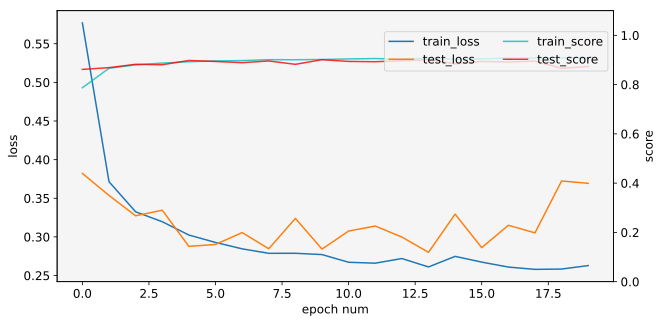

execute time is 907.268 seconds


In [10]:
model = VGG11()
model = model.cuda()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

# load data
mnist_train, mnist_test = download_data_fashion_mnist(resize=224)

params = {
    "epoch_num": 20,
    "data_num": len(mnist_train),
    "batch_size": 128,
    "gpu": True,
    "model": model,
    "loss": loss,
    "optimizer": optimizer,
    "draw": True,
#     "test_iter": Data.DataLoader(mnist_test, batch_size=128, shuffle=True),
    "evaluate": model.score,
#     "accum_step": 4,
    "draw_mean": True,
    "save_fig": True,
}

train_iter, test_iter = load_data_fashion_mnist(batch_size=params["batch_size"], num_workers=8, resize=224)
params["train_iter"] = train_iter
params["test_iter"] = test_iter

# training
train_epoch(**params)

### VGG16

In [5]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.conv = nn.Sequential(
            vgg_block(2, 1, 64),
            vgg_block(2, 64, 128),
            vgg_block(2, 128, 256),
            vgg_block(3, 256, 512),
            vgg_block(3, 512, 512),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.Dropout(0.5),
            nn.Linear(4096, 10)
        )
        
    def forward(self, x):
        output = self.conv(x)
        output = output.view(output.shape[0], -1)
        return self.fc(output)
    
    def score(self, x, y):
        y_pred = model(x)
        acc = (y_pred.argmax(dim=1) == y).sum().item() / len(y)
        return acc

In [6]:
model = VGG16()
model = model.cuda()
summary(model, input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
            Conv2d-2         [-1, 64, 224, 224]          36,928
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
            Conv2d-6        [-1, 128, 112, 112]         147,584
              ReLU-7        [-1, 128, 112, 112]               0
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         295,168
           Conv2d-10          [-1, 256, 56, 56]         590,080
             ReLU-11          [-1, 256, 56, 56]               0
        MaxPool2d-12          [-1, 256, 28, 28]               0
           Conv2d-13          [-1, 512, 28, 28]       1,180,160
           Conv2d-14          [-1, 512,

In [6]:
torch.backends.cudnn.benchmark=True

Epoch [1/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.6501, train_score: 0.759, test_loss: 0.3682, test_score: 0.867

Epoch [2/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3152, train_score: 0.885, test_loss: 0.2876, test_score: 0.895

Epoch [3/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2591, train_score: 0.906, test_loss: 0.2609, test_score: 0.907

Epoch [4/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2352, train_score: 0.914, test_loss: 0.2536, test_score: 0.906

Epoch [5/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.2158, train_score: 0.921, test_loss: 0.2556, test_score: 0.908

Epoch [6/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.1991, train_score: 0.927, test_loss: 0.2335, test_score: 0.916

Epoch [7/15]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.1832, train_score: 0.933, test_loss: 0.2314, test_score: 0.917

Epoch [8/15]
60000/60000 [>>>>>>>>

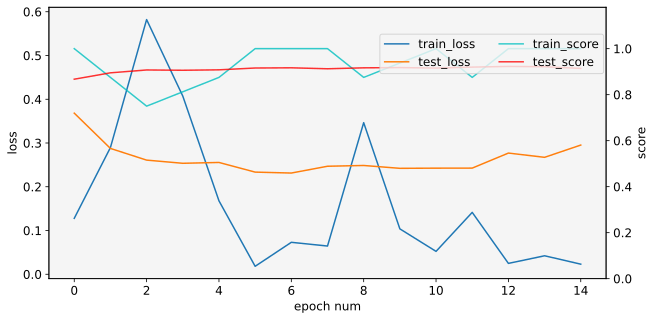

execute time is 12252.046 seconds


In [6]:
model = VGG16()
model = model.cuda()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
# load data
mnist_train, mnist_test = download_data_fashion_mnist(resize=224)

params = {
    "epoch_num": 15,
    "data_num": len(mnist_train),
    "batch_size": 16,
    "gpu": True,
    "model": model,
    "loss": loss,
    "optimizer": optimizer,
    "draw": True,
    "test_iter": Data.DataLoader(mnist_test, batch_size=32, num_workers=8, shuffle=True),
    "evaluate": model.score,
    "accum_step": 8,
}

train_iter, test_iter = load_data_fashion_mnist(batch_size=params["batch_size"], num_workers=8, resize=224)
params["train_iter"] = train_iter

# training
train_epoch(**params)

In [11]:
import os
if not os.path.exists("./model"):
    os.mkdir("./model")
    
torch.save(model.state_dict(), "./model/vgg16.pt")

## NIN

LeNet5/AlexNet/VGG等模型都是卷积加上全连接的结构
- 其中AlexNet/VGG通过加深和加宽网络（通道数）来获得更好的能力

而NIN使用了1x1的卷积来代替全连接，从而使得空间信息能够自然传递到后面的层中
- 高宽可以看作数据样本，通道看作特征

NIN依然使用11x11,5x5,3x3的卷积，相应的输出通道数和AlexNet相同，每个NIN模块后接上一个3x3,stride=2的最大池化
- 和AlexNet的另一个显著区别时，NIN去掉了AlexNet后面的3个全连接层，NIN使用输出通道等于标签类别数的NIN块，然后使用全局平局池化层对每个通道中的所有元素求平均直接分类。
- 可以显著减少模型参数尺寸，从而缓解过拟合

### 全局平均池化

实际上就是将每个通道的元素平均，得到一个等于通道数的向量

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [5]:
# 实验一下全局平均池化
a = torch.rand(3, 5, 5)
a[0].mean()
a[1].mean()
a[2].mean()

tensor(0.4460)

tensor(0.4702)

tensor(0.5072)

In [6]:
F.avg_pool2d(a, kernel_size=a.size()[2:])

tensor([[[0.4460]],

        [[0.4702]],

        [[0.5072]]])

### NIN网络实现

一个卷积后面接两个1x1的卷积

In [4]:
from torchsummary import summary
import torch.nn.functional as F

In [5]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
        
    def forward(self, x):
        return x.view(x.shape[0], -1)

# 实现nin模块
def nin_block(in_channels, out_channels, kernel_size, stride, padding):
    layer = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1),
        nn.ReLU(),
    )
    
    return layer


class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()
        
    def forward(self, x):
        return F.avg_pool2d(x, kernel_size=x.size()[2:])
    

class NinNet(nn.Module):
    def __init__(self):
        super(NinNet, self).__init__()
        self.layer = nn.Sequential(
            nin_block(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nin_block(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nin_block(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(0.5),
            nin_block(in_channels=384, out_channels=10, kernel_size=3, stride=1, padding=1),
            GlobalAvgPool2d(),
            FlattenLayer()
        )
        
    def forward(self, x):
        return self.layer(x)
    
    def score(self, x, y):
        y_pred = self.forward(x)
        acc = (y_pred.argmax(dim=1) == y).sum().item() / len(y)
        return acc

In [6]:
model = NinNet()
model = model.cuda()
summary(model, input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          11,712
              ReLU-2           [-1, 96, 55, 55]               0
            Conv2d-3           [-1, 96, 55, 55]           9,312
              ReLU-4           [-1, 96, 55, 55]               0
            Conv2d-5           [-1, 96, 55, 55]           9,312
              ReLU-6           [-1, 96, 55, 55]               0
         MaxPool2d-7           [-1, 96, 27, 27]               0
            Conv2d-8          [-1, 256, 27, 27]         614,656
              ReLU-9          [-1, 256, 27, 27]               0
           Conv2d-10          [-1, 256, 27, 27]          65,792
             ReLU-11          [-1, 256, 27, 27]               0
           Conv2d-12          [-1, 256, 27, 27]          65,792
             ReLU-13          [-1, 256, 27, 27]               0
        MaxPool2d-14          [-1, 256,

Epoch [1/20]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 1.5710, train_score: 0.415, test_loss: 0.6827, test_score: 0.754

Epoch [2/20]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.6143, train_score: 0.778, test_loss: 0.5280, test_score: 0.813

Epoch [3/20]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.5036, train_score: 0.818, test_loss: 0.4526, test_score: 0.841

Epoch [4/20]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.4425, train_score: 0.839, test_loss: 0.4215, test_score: 0.850

Epoch [5/20]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.4030, train_score: 0.853, test_loss: 0.4044, test_score: 0.855

Epoch [6/20]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3831, train_score: 0.860, test_loss: 0.3605, test_score: 0.868

Epoch [7/20]
60000/60000 [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] - train_loss: 0.3644, train_score: 0.866, test_loss: 0.3757, test_score: 0.864

Epoch [8/20]
60000/60000 [>>>>>>>>

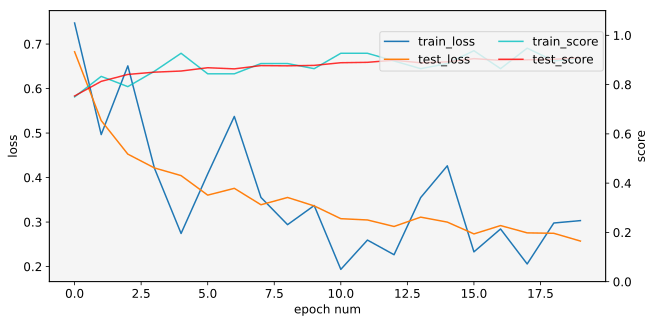

execute time is 1069.716 seconds


In [7]:
# define model
model = NinNet()
model = model.cuda()
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

# load data
mnist_train, mnist_test = download_data_fashion_mnist(resize=224)

params = {
    "epoch_num": 20,
    "data_num": len(mnist_train),
    "batch_size": 256,
    "gpu": True,
    "model": model,
    "loss": loss,
    "optimizer": optimizer,
    "draw": True,
    "evaluate": model.score,
#     "accum_step": 8,
}

train_iter, test_iter = load_data_fashion_mnist(batch_size=params["batch_size"], num_workers=8, resize=224)
params["train_iter"] = train_iter
params["test_iter"] = test_iter

# training
train_epoch(**params)

- NIN重复使用由卷积层和代替全连接层的1x1卷积层构成的NiN块来构建深层网络
- NiN去除了容易造成过拟合的全连接输出层，将其替换成输出通道等于标签类别数的NiN块和全局平均池化层
- NiN的以上设计思想影响了后面一系列卷积神经网络的设计

## GoogleNet

### 局部响应归一化

In [6]:
# 通道间的局部响应归一化
class LRN(nn.Module):
    def __init__(self, n, k=1.0, alpha=1e-4, beta=0.75):
        super(LRN, self).__init__()
        self.n = n
        self.k = k
        self.alpha = alpha
        self.beta = beta
        
    def inter_lrn(self, output):
        # 获取输出的形状
        c, h, w = output.shape
        # 生成一个shape和output一样的向量
        lrn_output = torch.zeros_like(output, dtype=torch.float32, device=output.device)
        for x in range(h):
            for y in range(w):
                for i in range(c):
                    # 按照公式
                    temp = (output[int(max(0,i-self.n/2)):int(min(c-1, i+self.n/2)+1), x, y]**2).sum()
                    lrn_output[i, x, y] = output[i, x, y] / ((self.k + self.alpha * temp)**self.beta)
        return lrn_output
    
    def batch_lrn(self, x):
        batch = x.shape[0]
        temp = self.inter_lrn(x[0])
        for b in range(1, batch):
            temp = torch.stack((temp, self.inter_lrn(x[b])))
        
        # 如果batch size为1，就增加一个维度
        if len(temp.shape) == 3:
            temp = temp.unsqueeze(0)
        return temp
    
    def forward(self, x):
        return self.batch_lrn(x)

### GoogleNet实现

In [8]:
import sys
import torch
import torch.nn as nn
from torchsummary import summary
import torch.nn.functional as F
sys.path.append("../d2l_func/")
from model_train import train_epoch

In [9]:
# 创建inception
class Inception(nn.Module):
    """
    function: realize the Inception model in GoogleNet
    params in_c: the channels of input
    params c1: the channels of the route1
    params c2: the channels of the route2 
    params c3: the channels of the route3
    params c4: the channesl of the route4
    """
    def __init__(self, in_c, c1, c2, c3, c4):
        super(Inception, self).__init__()
        self.route1 = nn.Sequential(
            nn.Conv2d(in_channels=in_c, out_channels=c1, kernel_size=1),
            nn.ReLU(),
        )
        self.route2 = nn.Sequential(
            nn.Conv2d(in_channels=in_c, out_channels=c2[0], kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=c2[0], out_channels=c2[1], kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.route3 = nn.Sequential(
            nn.Conv2d(in_channels=in_c, out_channels=c3[0], kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=c3[0], out_channels=c3[1], kernel_size=5, padding=2),
            nn.ReLU(),
        )
        self.route4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            nn.Conv2d(in_channels=in_c, out_channels=c4, kernel_size=1),
            nn.ReLU(),
        )
        
    def forward(self, x):
        output1 = self.route1(x)
        output2 = self.route2(x)
        output3 = self.route3(x)
        output4 = self.route4(x)
        output = torch.cat((output1, output2, output3, output4), dim=1)
        return output

GoogleNet使用了5个block，每个block之间使用3x3(stride=2)的最大池化
- 输入1x224x224
- 第一个block使用64x1x7x7的卷积核, stride=2, padding=3, 输出64x111x111, 紧接着用3x3, stride=2的最大池化，得到64x55x55的输出
- 第二个block使用64x64x1x1的卷积核，stride=1, 得到64x55x55的输出，使用192x64x3x3(stride=1, padding=1)的卷积，得到192x54x54的输出, 使用3x3(stride=2)的最大池化，得到192x27x27的输出
- 第三个block串联使用两个完整的inception模块,
    - 第一个inception模块的输出通道为64, 128, 32, 32(2:4:1:1), 拼接起来就是256。其中，第二，三条inception模块的输入通道到96/192=1/2，16/192=1/12，再接上第二层卷积
    - 第二个inception模块的输出通道为128，192，96，64(4:6:3:2)，拼接起来就是480。其中，第二，三条inception模块的输入通道减少到128/256=1/2，32/256=1/8
    - 输出480x27x27，再接一个3x3(stride=2)的pooling，得到480x13x13
- 第四个block串联了5个inception块，其输出通道为192+208+48+64=512(12:13:3:4), 160+224+64+64=512(5:7:2:2), 128+256+64+64=512(2:4:1:1)，112+288+64+64=528(7:18:4:4)，256+320+128+128(4:5:2:2)=832
    - 第2条线路的通道数最多，第1线路次之，紧接着是第3，4条，其中第2，3条都会按比例减少通道数，但是这个比例各不相同
    - 得到832x13x13的输出，再接一个3x3(stride=2)的pooling，得到832x6x6
- 第五个block有2个inception块，输出通道数为256+320+128+128=832, 384+384+128+128=1024，每条线路的通道数分配思路和第3，4模块的一致，只是在具体数值上有所不同
- 第五个模块紧跟着输出层，使用全局平均池化，最后将2维数组接上一个输出个数维标签类别数的全连接层

In [10]:
class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        super(GlobalAvgPool2d, self).__init__()
        
    def forward(self, x):
        return F.avg_pool2d(x, kernel_size=x.size()[2:])

    
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
        
    def forward(self, x):
        return x.view(x.shape[0], -1)
    
    
class GoogleNet(nn.Module):
    def __init__(self):
        super(GoogleNet, self).__init__()
        # 第一个模块的输出通道为
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
#             LRN(4)
#             nn.LocalResponseNorm(5)
            # 使用BatchNorm2d来代替原来的局部响应归一化
#             nn.BatchNorm2d(64)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=192, kernel_size=3, padding=1, stride=1),
            # 使用BatchNorm2d来代替原来的局部响应归一化
#             nn.BatchNorm2d(192),
            nn.ReLU(),
#             LRN(4),
#             nn.LocalResponseNorm(5),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.block3 = nn.Sequential(
            Inception(192, 64, (96, 128), (16, 32), 32),
            Inception(256, 128, (128, 192), (32, 96), 64),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.block4 = nn.Sequential(
            Inception(480, 192, (96, 208), (16, 48), 64),
            Inception(512, 160, (112, 224), (24, 64), 64),
            Inception(512, 128, (128, 256), (24, 64), 64),
            Inception(512, 112, (144, 288), (32, 64), 64),
            Inception(528, 256, (160, 320), (32, 128), 128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        self.block5 = nn.Sequential(
            Inception(832, 256, (160, 320), (32, 128), 128),
            Inception(832, 384, (192, 384), (48, 128), 128),
            GlobalAvgPool2d()
        )
        self.layer = nn.Sequential(
            self.block1,
            self.block2,
            self.block3,
            self.block4,
            self.block5,
            FlattenLayer(),
            nn.Linear(1024, 10),
        )
        
    def forward(self, x):
        return self.layer(x)
        
    def score(self, x, y):
        y_pred = self.forward(x)
        acc = (y_pred.argmax(dim=1) == y).sum().item() / len(y)
        return acc

In [8]:
model = GoogleNet()
model = model.cuda()
summary(model, input_size=(1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,200
            Conv2d-2         [-1, 64, 112, 112]           3,200
              ReLU-3         [-1, 64, 112, 112]               0
              ReLU-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 55, 55]               0
         MaxPool2d-6           [-1, 64, 55, 55]               0
            Conv2d-7           [-1, 64, 55, 55]           4,160
            Conv2d-8           [-1, 64, 55, 55]           4,160
              ReLU-9           [-1, 64, 55, 55]               0
             ReLU-10           [-1, 64, 55, 55]               0
           Conv2d-11          [-1, 192, 55, 55]         110,784
           Conv2d-12          [-1, 192, 55, 55]         110,784
             ReLU-13          [-1, 192, 55, 55]               0
             ReLU-14          [-1, 192,

In [ ]:
# define model
model = GoogleNet()
model = model.cuda()
# loss and optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
# load data
mnist_train, mnist_test = download_data_fashion_mnist()

params = {
    "epoch_num": 15,
    "model": model,
    "data_num": len(mnist_train),
    "loss": loss,
    "optimizer": optimizer,
    "draw": True,
    "gpu": True,
    "batch_size": 62,
    "evaluate": model.score,
    "draw_mean": True,
    "save_fig": True,
    "save_path": "../result/GoogleNet对比试验/img/"
}

train_iter, test_iter = load_data_fashion_mnist(batch_size=params["batch_size"] , num_workers=16, resize=224)
params["train_iter"] = train_iter
params["test_iter"] = test_iter

# training
train_epoch(**params)

Epoch [1/15]


- Inception模块相当于一个有4条线路的子网络，通过不同窗口形状的卷积层和最大池化层来并行抽取信息，并用1x1卷积来减少通道数来降低模型复杂度
- GoogleNet将多个设计精细的Inception块和其他层串联起来，其中Inception块的通道数分配之比是通过大量实验得来的
- GoogleNet和它们的后继者是ImageNet上最高效的模型之一，在类似的测试精度下，它们的计算复杂度往往更低